<a href="https://colab.research.google.com/github/evriitt/from_idea_to_mvp/blob/main/cars_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подержанные автомобили

Датасет содержит информацию о характеристиках и ценах подержанных автомобилей в некоторой стране

## Импорт библиотек, константы

In [349]:
!pip install catboost -q

In [399]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

In [351]:
sns.set_style("darkgrid")
plt.rc('figure', figsize=(17, 5))
pd.set_option('display.max_columns', None)   # Настройка отображения графиков

In [352]:
random.seed(43)
np.random.seed(43) # Фиксация случайностей

In [353]:
DATASET_PATH = "https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/cars.csv"

## Загрузка и обзор данных

### Загрузка

In [354]:
df = pd.read_csv(DATASET_PATH)   # загрузка данных

### Описание данных

**Целевая переменная**
- `selling_price`: цена продажи, числовая

**Признаки**
- `name` (string): модель автомобиля
- `year` (numeric, int): год выпуска с завода-изготовителя
- `km_driven` (numeric, int): пробег на дату продажи
- `fuel` (categorical: _Diesel_ или _Petrol_, или _CNG_, или _LPG_, или _electric_): тип топлива
- `seller_type` (categorical: _Individual_ или _Dealer_, или _Trustmark Dealer_): продавец
- `transmission` (categorical: _Manual_ или _Automatic_): тип трансмиссии
- `owner` (categorical: _First Owner_ или _Second Owner_, или _Third Owner_, или _Fourth & Above Owner_): какой по счёту хозяин?
- `mileage` (string, по смыслу числовой): пробег, требует предобработки
- `engine` (string, по смыслу числовой): рабочий объем двигателя, требует предобработки
- `max_power` (string, по смыслу числовой): пиковая мощность двигателя, требует предобработки
- `torque` (string, по смыслу числовой, а то и 2): крутящий момент, требует предобработки
- `seats` (numeric, float; по смыслу categorical, int)

In [355]:
df.info() # пропуски в 5 столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [356]:
df.sample(3)# случайные три записи из датасета

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6334,Maruti Swift Dzire Vdi BSIV,2012,371000,100000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
211,Mahindra XUV500 W8 2WD,2012,535000,120000,Diesel,Individual,Manual,First Owner,15.1 kmpl,2179 CC,140 bhp,330Nm@ 1600-2800rpm,7.0
3582,Hyundai i20 Asta 1.2,2015,500000,70000,Petrol,Individual,Manual,First Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


## Предобработка

In [357]:
print("Общее количество дубликатов:", df.duplicated().sum()) # Посмотрим дуюликаты, их 985

# Вывод строк, являющихся дубликатами
duplicate_rows = df[df.duplicated(keep=False)]
print("Дублирующиеся строки:")
duplicate_rows.sort_values('name')

Общее количество дубликатов: 985
Дублирующиеся строки:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1703,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
6307,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
1836,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
6704,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
1337,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0
3291,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0
5753,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0
361,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0


In [358]:
df = df.drop_duplicates() # Удаляем

In [359]:
df['selling_price'] = df['selling_price'] /1000    # Для удобства уменьшим разрядность
df['km_driven'] = df['km_driven'] /1000

<ipython-input-359-ba8e38d6cc87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selling_price'] = df['selling_price'] /1000    # Для удобства уменьшим разрядность
<ipython-input-359-ba8e38d6cc87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['km_driven'] = df['km_driven'] /1000


In [360]:
df.describe(include='all') # посмотрим на столбцы. Все ок только с годом (1983 - 2020)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
count,6014,6014.000000,6014.000000,6014.000000,6014,6014,6014,6014,5824,5824,5827,5823,5824.000000
unique,1924,NaN,NaN,NaN,4,3,2,5,386,120,316,419,NaN
top,Maruti Swift Dzire VDI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,NaN
freq,107,NaN,NaN,NaN,3269,5394,5505,3721,184,795,282,417,NaN
mean,NaN,2013.447456,521.982030,73.764150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.437672
std,NaN,4.079920,533.842622,59.610747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991755
min,NaN,1983.000000,29.999000,0.001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
25%,NaN,2011.000000,250.000000,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,2014.000000,409.999000,70.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
75%,NaN,2017.000000,640.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


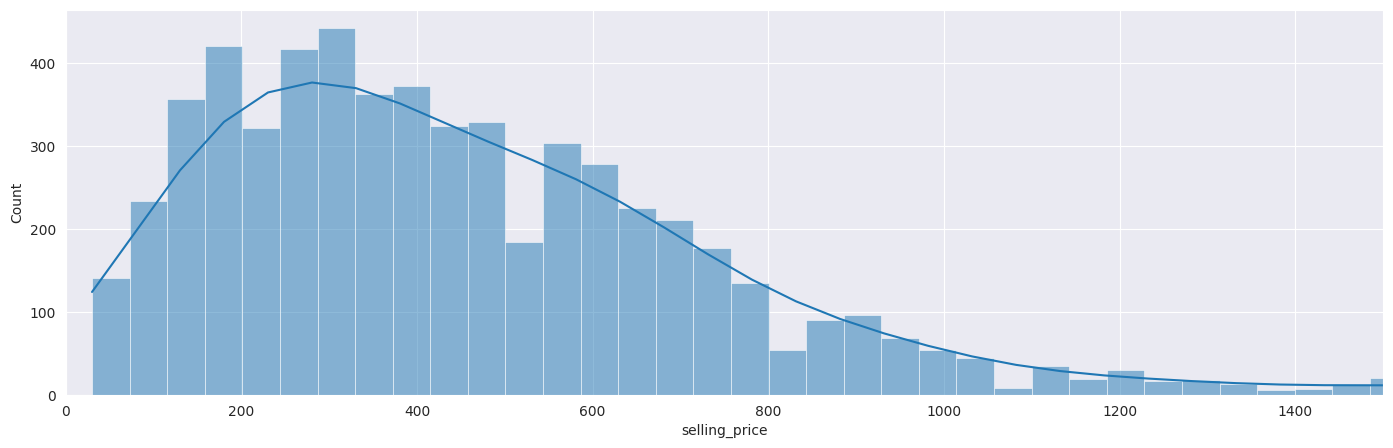

In [361]:
sns.histplot(df['selling_price'], kde=True); # Посмотрим на цену
plt.xlim(0, 1500);

In [362]:
df  = df[df['selling_price'] <= 1000] # Отсечем хвост до отметки 1млн

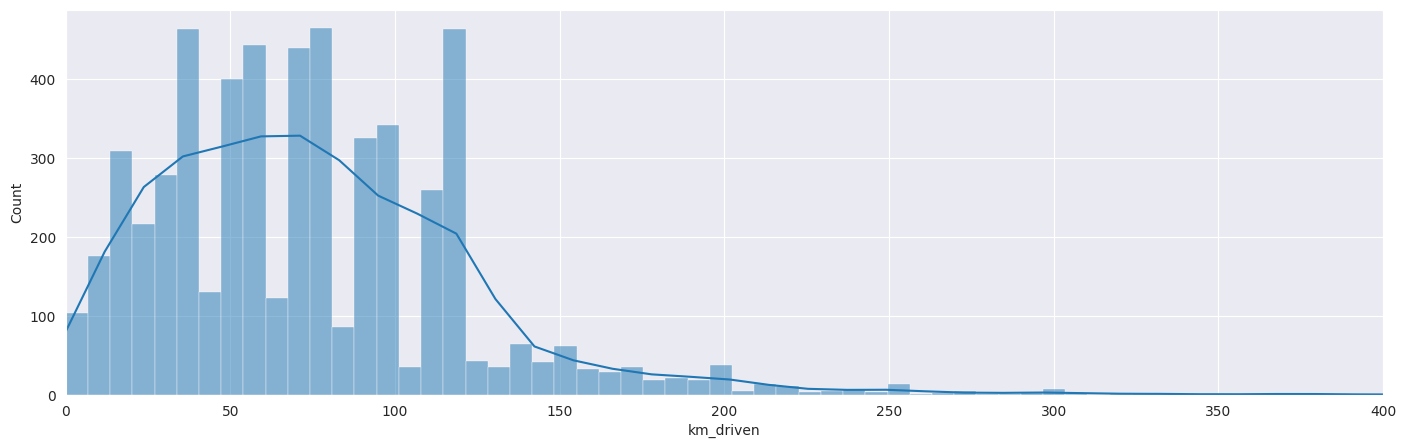

In [363]:
sns.histplot(df['km_driven'], kde=True) ; # Тут похожая проблема
plt.xlim(0, 400);

In [364]:
df = df[df['km_driven'] <= 200] # Отсечен хвост до отметки 200 тыс.км

In [365]:
df['fuel'].value_counts() # 4 вида топлива

Diesel    2814
Petrol    2593
CNG         50
LPG         33
Name: fuel, dtype: int64

In [366]:
df['seller_type'].value_counts() #Trustmark Dealer не является отдельной группой продавцов, к тому же, таких строк слишком мало, отнесем их просто к дилерам

Individual          5003
Dealer               464
Trustmark Dealer      23
Name: seller_type, dtype: int64

In [367]:
df['seller_type'] = df['seller_type'].replace({ 'Trustmark Dealer': 'Dealer'})

<ipython-input-367-25fd90ed1196>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seller_type'] = df['seller_type'].replace({ 'Trustmark Dealer': 'Dealer'})


In [368]:
df['owner'].value_counts() # Объединим в три группы

First Owner             3334
Second Owner            1586
Third Owner              438
Fourth & Above Owner     132
Name: owner, dtype: int64

In [369]:
df['seller_type'] = df['seller_type'].replace({ 'Fourth & Above Owner': 'Third & Above Owner'})

In [370]:
df['transmission'].value_counts() # КПП 2 вида

Manual       5196
Automatic     294
Name: transmission, dtype: int64

In [371]:
def extract_numeric_value(df, column_name):
    for index, value in enumerate(df[column_name].unique()):                                        # Обработаем 3 столбца mileage,	engine,	max_power - извлечем числовую информацию, остальные символы удалим
        match = re.search(r'(\d+\.\d+|\d+)', str(value))
        if match:
            numeric_value = float(match.group())
            df.loc[df[column_name] == value, column_name] = numeric_value
    return df

In [372]:
extract_numeric_value(df,  'mileage')
extract_numeric_value(df,  'engine')
extract_numeric_value(df,  'max_power')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450.0,145.5,Diesel,Individual,Manual,First Owner,23.4,1248.0,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370.0,120.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225.0,127.0,Diesel,Individual,Manual,First Owner,23.0,1396.0,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130.0,120.0,Petrol,Individual,Manual,First Owner,16.1,1298.0,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440.0,45.0,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,Hyundai Santro Xing GLS,2008,120.0,191.0,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.1,96.1Nm@ 3000rpm,5.0
6993,Maruti Wagon R VXI BS IV with ABS,2013,260.0,50.0,Petrol,Individual,Manual,Second Owner,18.9,998.0,67.1,90Nm@ 3500rpm,5.0
6994,Hyundai i20 Magna,2013,320.0,110.0,Petrol,Individual,Manual,First Owner,18.5,1197.0,82.85,113.7Nm@ 4000rpm,5.0
6995,Hyundai Verna CRDi SX,2007,135.0,119.0,Diesel,Individual,Manual,Fourth & Above Owner,16.8,1493.0,110.0,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [373]:
# Функция для извлечения числовых значений из torque.
def extract_nm(text):
    pattern = r'(\d+(\.\d+)?)'  # Регулярное выражение для извлечения числового значения nm
    match = re.search(pattern, str(text))
    if match:
        return float(match.group(1))
    else:
        return None

df['nm'] = df['torque'].apply(extract_nm)# Применение функций к столбцу 'torque'

In [374]:
"""def extract_rpm(text):
#  Извлекает  значения rpm

    pattern = r'@(?:\s*)?(\d+(?:[.,]\d+)?(?:-\d+(?:[.,]\d+)?)?)|at\s*(\d+(?:[.,]\d+)?(?:-\d+(?:[.,]\d+)?)?)'
    matches = re.findall(pattern, str(text))

    rpm_values = []
    for match in matches:
        for value in match:
            if value:
                value = value.replace(',', '').replace('.', '')  # Осторожно, костыли!
                if '-' in value:
                    # Обработка чисел, указанных в диапазоне
                    min_value, max_value = map(float, re.findall(r'\d+(?:[.,]\d+)?', value))
                    average_value = (min_value + max_value) / 2
                    rpm_values.append(average_value)
                else:
                    # Обработка отдельных чисел
                    rpm_values.append(float(value))

    if rpm_values:
        return rpm_values[0]  # Возвращает только первое число из списка
    else:
        return None

df['rpm'] = df['torque'].apply(extract_rpm)"""

"def extract_rpm(text):\n#  Извлекает  значения rpm\n  \n    pattern = r'@(?:\\s*)?(\\d+(?:[.,]\\d+)?(?:-\\d+(?:[.,]\\d+)?)?)|at\\s*(\\d+(?:[.,]\\d+)?(?:-\\d+(?:[.,]\\d+)?)?)'\n    matches = re.findall(pattern, str(text))\n\n    rpm_values = []\n    for match in matches:\n        for value in match:\n            if value:\n                value = value.replace(',', '').replace('.', '')  # Осторожно, костыли!\n                if '-' in value:\n                    # Обработка чисел, указанных в диапазоне\n                    min_value, max_value = map(float, re.findall(r'\\d+(?:[.,]\\d+)?', value))\n                    average_value = (min_value + max_value) / 2\n                    rpm_values.append(average_value)\n                else:\n                    # Обработка отдельных чисел\n                    rpm_values.append(float(value))\n\n    if rpm_values:\n        return rpm_values[0]  # Возвращает только первое число из списка\n    else:\n        return None\n\ndf['rpm'] = df['torqu

In [375]:
df.sample(8)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,nm
2160,Maruti Alto LXi BSIII,2008,100.0,70.0,Petrol,Individual,Manual,Third Owner,19.7,796.0,46.3,62Nm@ 3000rpm,5.0,62.00
6520,Maruti Baleno Alpha 1.2,2016,650.0,35.0,Petrol,Individual,Manual,Second Owner,21.4,1197.0,83.1,115Nm@ 4000rpm,5.0,115.00
3941,Maruti Swift Dzire VDI,2019,694.0,35.0,Diesel,Individual,Manual,First Owner,28.4,1248.0,74.02,190Nm@ 2000rpm,5.0,190.00
5785,Peugeot 309 GLD,1997,57.0,110.0,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN,NaN
3974,Maruti Ertiga ZDI,2013,600.0,60.0,Diesel,Individual,Manual,Third Owner,20.77,1248.0,88.8,200Nm@ 1750rpm,7.0,200.00
4650,Volkswagen Polo 1.5 TDI Comfortline,2014,575.0,40.0,Diesel,Individual,Manual,Third Owner,20.14,1498.0,88.8,230Nm@ 1500-2500rpm,5.0,230.00
4213,Hyundai i20 Asta 1.4 CRDi,2012,400.0,100.0,Diesel,Individual,Manual,First Owner,21.27,1396.0,88.76,219.6Nm@ 1500-2750rpm,5.0,219.60
6526,Hyundai Grand i10 SportZ Edition,2015,499.0,20.0,Petrol,Individual,Manual,First Owner,18.9,1197.0,81.86,113.75Nm@ 4000rpm,5.0,113.75


In [376]:
df = df.dropna()  # Удаляем строки, которые не получилось обработать

In [377]:
df['mileage'] = df['mileage'].astype('float')
df['engine'] = df['engine'].astype('float')
df['max_power'] = df['max_power'].astype('float') # Столбцы сохранили тип object, нужно изменить тип

<ipython-input-377-8ba7907aa49d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mileage'] = df['mileage'].astype('float')
<ipython-input-377-8ba7907aa49d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['engine'] = df['engine'].astype('float')
<ipython-input-377-8ba7907aa49d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6996
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5304 non-null   object 
 1   year           5304 non-null   int64  
 2   selling_price  5304 non-null   float64
 3   km_driven      5304 non-null   float64
 4   fuel           5304 non-null   object 
 5   seller_type    5304 non-null   object 
 6   transmission   5304 non-null   object 
 7   owner          5304 non-null   object 
 8   mileage        5304 non-null   float64
 9   engine         5304 non-null   float64
 10  max_power      5304 non-null   float64
 11  torque         5304 non-null   object 
 12  seats          5304 non-null   float64
 13  nm             5304 non-null   float64
dtypes: float64(7), int64(1), object(6)
memory usage: 621.6+ KB


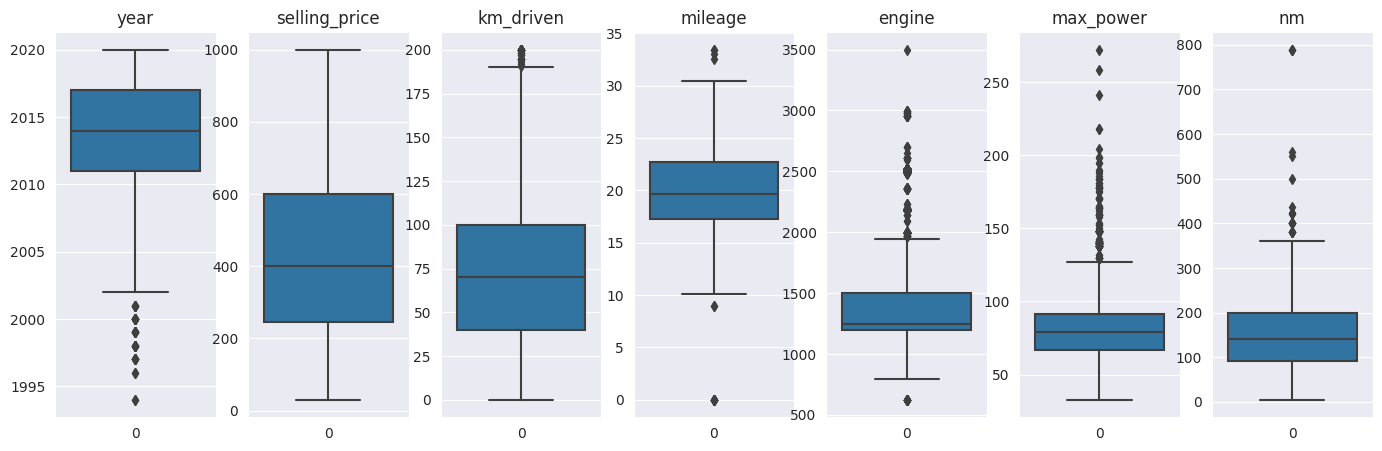

In [379]:
fig, axes = plt.subplots(1, 7, figsize=(17, 5))

# Построение боксплотов для каждого столбца
for i, column in enumerate(df[['year',	'selling_price',	'km_driven','mileage','engine','max_power','nm']]):
    sns.boxplot(data=df[column], ax=axes[i])
    axes[i].set_title(column)

plt.show()# Отображение графиков

In [380]:
df = df[df['year'] >= 1995] # Удалим выбивающиеся значения
df = df[df['engine'] <= 3000]
df = df[df['nm'] <= 500]
df = df[df['mileage'] > 2]

df.reset_index(inplace=True)# Сброс индексов

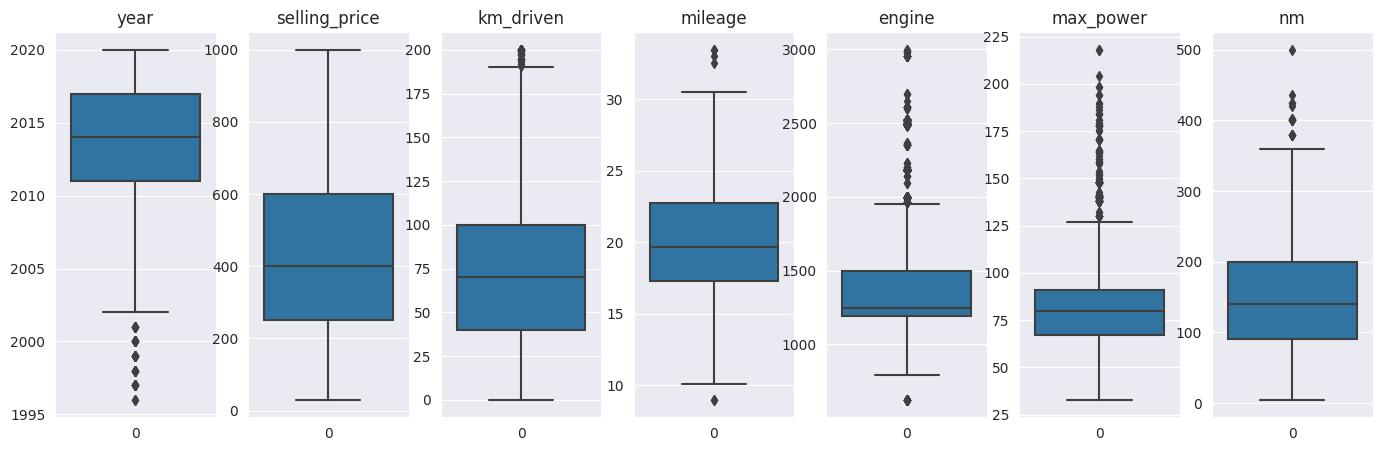

In [381]:
fig, axes = plt.subplots(1, 7, figsize=(17, 5))

for i, column in enumerate(df[['year',	'selling_price',	'km_driven',	'mileage','engine','max_power','nm']]):  # Посмотрим что получилось
    sns.boxplot(data=df[column], ax=axes[i])
    axes[i].set_title(column)
plt.show()

In [382]:
df['mark'] = df['name'].str.extract(r'^(\w+)')
df['model'] = df['name'].str.extract(r'^\w+\s+(\w+)')   # Достаем Название модели и марке из столбца name

In [383]:
df['model'] = df['model'].fillna(df['name'].str.extract(r'Mercedes-Benz\s+([A-Za-z]{1,3})(?:\s*-)?\s*Class', expand=False)) # Отдельно обрабатываем мерседесы
df['model'] = df['model'].fillna(df['name'].str.extract(r'Mercedes-Benz\s+(\w+\sC)', expand=False))

In [384]:
df.sample(10)

,index,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,nm,mark,model
323,423,Maruti A-Star Vxi,2010,200.0,65.000,Petrol,Individual,Manual,Second Owner,19.00,998.0,66.10,90Nm@ 3500rpm,5.0,90.0,Maruti,A
2192,2748,Tata Indigo CS eLX BS IV,2014,215.0,100.000,Diesel,Individual,Manual,Second Owner,25.00,1396.0,69.01,140Nm@ 1800-3000rpm,5.0,140.0,Tata,Indigo
578,727,Ford EcoSport 1.5 TDCi Titanium Plus BSIV,2015,615.0,80.000,Diesel,Individual,Manual,First Owner,22.77,1498.0,98.59,205Nm@ 1750-3250rpm,5.0,205.0,Ford,EcoSport
4766,6250,Ford Figo Diesel Titanium,2012,250.0,80.000,Diesel,Individual,Manual,Second Owner,20.00,1399.0,68.00,160Nm@ 2000rpm,5.0,160.0,Ford,Figo
599,750,Maruti Ertiga VDI,2015,750.0,14.000,Diesel,Individual,Manual,First Owner,20.77,1248.0,88.76,200Nm@ 1750rpm,7.0,200.0,Maruti,Ertiga
4668,6137,Hyundai Xcent 1.2 Kappa S,2014,480.0,30.000,Petrol,Individual,Manual,First Owner,19.10,1197.0,82.00,114Nm@ 4000rpm,5.0,114.0,Hyundai,Xcent
2398,3017,Mahindra Bolero 2011-2019 ZLX BSIII,2014,530.0,120.000,Diesel,Individual,Manual,Third Owner,15.96,2523.0,62.10,195Nm@ 1400-2200rpm,7.0,195.0,Mahindra,Bolero
791,1044,Tata Nano CX,2013,80.0,30.000,Petrol,Individual,Manual,First Owner,25.40,624.0,37.48,51Nm@ 4000+/-500rpm,4.0,51.0,Tata,Nano
3432,4517,Volkswagen CrossPolo 1.5 TDI,2013,350.0,70.000,Diesel,Individual,Manual,Second Owner,20.14,1498.0,88.50,230Nm@ 1500-2500rpm,5.0,230.0,Volkswagen,CrossPolo
1640,2050,Maruti Swift Dzire AMT VXI,2017,600.0,26.634,Petrol,Dealer,Automatic,First Owner,21.21,1197.0,81.80,113Nm@ 4200rpm,5.0,113.0,Maruti,Swift


In [388]:
data = df[[ 'year',  'km_driven', 'fuel',
       'seller_type', 'transmission', 'owner', 'mileage', 'engine',
       'max_power',  'nm', 'mark', 'model']]
y = df['selling_price']

In [390]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2)# Разделение данных на обучающую и тестовую выборки

In [391]:
x_train

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,nm,mark,model
3327,2016,25.0,Petrol,Individual,Manual,First Owner,18.90,1197.0,82.00,114.0,Hyundai,Grand
2859,2012,110.0,Diesel,Individual,Manual,First Owner,19.30,1248.0,73.90,190.0,Maruti,Swift
3531,2011,70.0,Petrol,Individual,Manual,Third Owner,20.36,1197.0,78.90,111.8,Hyundai,i10
1096,2015,70.0,Petrol,Individual,Manual,Third Owner,23.10,998.0,67.04,90.0,Maruti,Celerio
2717,2013,60.0,Diesel,Individual,Manual,First Owner,12.05,2179.0,120.00,290.0,Mahindra,Scorpio
...,...,...,...,...,...,...,...,...,...,...,...,...
1211,2014,132.0,Diesel,Individual,Manual,Second Owner,19.72,1461.0,108.45,245.0,Renault,Duster
710,2008,120.0,Petrol,Individual,Manual,Second Owner,17.00,1497.0,118.00,146.0,Honda,City
1517,2016,40.0,Diesel,Individual,Manual,First Owner,28.09,1248.0,88.50,200.0,Maruti,Ciaz
4792,2015,80.0,Diesel,Individual,Manual,First Owner,23.90,1582.0,126.32,259.8,Hyundai,Verna


In [394]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Исключение значений, равных нулю, чтобы избежать деления на ноль
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    percentage_errors = np.abs((y_true - y_pred) / y_true) * 100 # Расчет процентного отклонения для каждого наблюдения
    mape = np.mean(percentage_errors)    # Расчет среднего значения процентного отклонения

    return "Средня ошибка в процентах", round(mape,2)

In [397]:
%%time
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner', 'mark', 'model']# Задание категориальных признаков

model = CatBoostRegressor()# Создание модели CatBoostRegressor

param_grid = {
    'l2_leaf_reg': [1, 3, 5],                               # Задание сетки гиперпараметров для подбора
    'iterations': [200],
    'learning_rate': [0.1, 0.05, 0.6],
    'depth': [7, 10, 14]}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error') # Создание объекта GridSearchCV и обучение модели с подбором гиперпараметров
grid_search.fit(x_train, y_train, cat_features=categorical_features)


Выходные данные были обрезаны до нескольких последних строк (5000).
2:	learn: 206.4626837	total: 766ms	remaining: 50.3s
3:	learn: 199.6423397	total: 1.14s	remaining: 56.1s
4:	learn: 193.7565645	total: 1.23s	remaining: 47.9s
5:	learn: 187.6538792	total: 1.64s	remaining: 53s
6:	learn: 181.8215459	total: 2.03s	remaining: 56s
7:	learn: 176.4430069	total: 2.19s	remaining: 52.6s
8:	learn: 171.2778101	total: 2.56s	remaining: 54.3s
9:	learn: 166.5967075	total: 2.73s	remaining: 52s
10:	learn: 162.0589937	total: 3.11s	remaining: 53.5s
11:	learn: 157.8034016	total: 3.13s	remaining: 49s
12:	learn: 153.6371773	total: 3.14s	remaining: 45.2s
13:	learn: 149.6658119	total: 3.53s	remaining: 47s
14:	learn: 145.8199916	total: 3.93s	remaining: 48.4s
15:	learn: 142.1676955	total: 3.94s	remaining: 45.3s
16:	learn: 138.6563771	total: 4.29s	remaining: 46.2s
17:	learn: 135.4421371	total: 4.68s	remaining: 47.4s
18:	learn: 132.7862738	total: 4.69s	remaining: 44.7s
19:	learn: 129.7368730	total: 5.07s	remaining: 45

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe278710220>,
             param_grid={'depth': [7, 10, 14], 'iterations': [200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.05, 0.6]},
             scoring='neg_mean_absolute_error')

In [400]:
print("Best parameters:", grid_search.best_params_)# Вывод лучших гиперпараметров и значения метрики
print("Best MAE:", -grid_search.best_score_)


best_model = grid_search.best_estimator_ # Получение модели с наилучшими гиперпараметрами
best_model.fit(x_train, y_train, cat_features=categorical_features) # Обучение лучшей модели


y_pred = best_model.predict(x_test)  # Предсказание


mae = mean_absolute_error(y_test, y_pred) # Расчет метрики MAPE
print('mae:', mae)
print(*mean_absolute_percentage_error(y_test, y_pred))

Best parameters: {'depth': 7, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best MAE: 54.32998191156902
0:	learn: 212.1081480	total: 21.9ms	remaining: 4.37s
1:	learn: 197.9817667	total: 45.2ms	remaining: 4.48s
2:	learn: 186.1229300	total: 64.1ms	remaining: 4.21s
3:	learn: 175.8975697	total: 77.2ms	remaining: 3.78s
4:	learn: 165.5945381	total: 99.8ms	remaining: 3.89s
5:	learn: 156.1621315	total: 121ms	remaining: 3.9s
6:	learn: 148.0633632	total: 144ms	remaining: 3.98s
7:	learn: 141.1833786	total: 164ms	remaining: 3.94s
8:	learn: 134.5771331	total: 189ms	remaining: 4.01s
9:	learn: 128.2682472	total: 206ms	remaining: 3.92s
10:	learn: 122.7393136	total: 232ms	remaining: 3.98s
11:	learn: 117.9449311	total: 247ms	remaining: 3.87s
12:	learn: 113.3100273	total: 269ms	remaining: 3.87s
13:	learn: 110.0121847	total: 281ms	remaining: 3.73s
14:	learn: 106.6274013	total: 301ms	remaining: 3.72s
15:	learn: 103.6935396	total: 319ms	remaining: 3.67s
16:	learn: 101.0205589	total: 341ms	remai

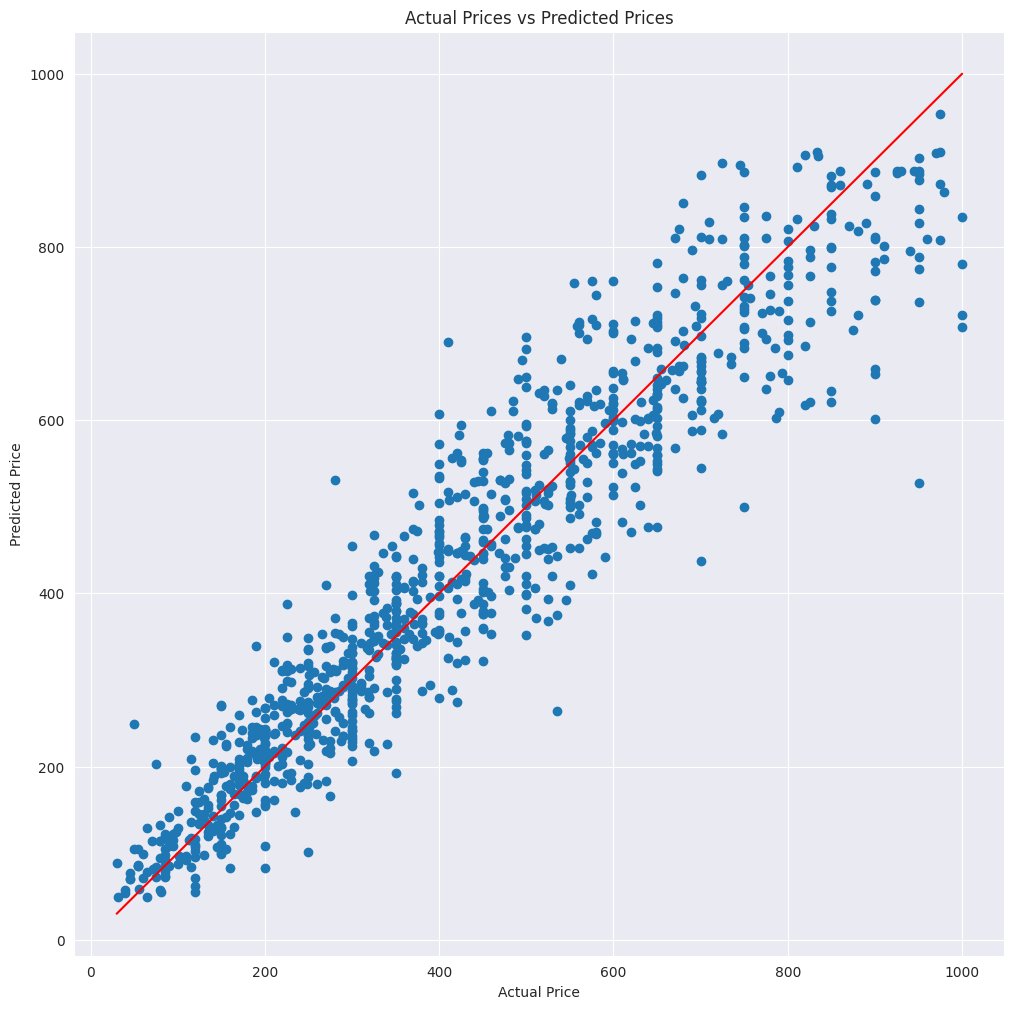

In [401]:
plt.figure(figsize=(12, 12))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()